In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

from train import create_model, create_criterion, evaluate
from dataset import TrainData, TrainDataset

In [2]:
input_dir = "/storage/kaggle/quickdraw"
model_type = "cnn"
model_name = "baseline"
loss_type = "cce"
image_size = 128
use_extended_stroke_channels = True
augment = False
batch_size = 64
test_size = 0.1
train_on_unrecognized = True
num_category_shards = 1
category_shard = 0
exclude_categories = False
num_categories = 340 // num_category_shards
num_workers = 8
pin_memory = True
use_dummy_image = False
predict_on_val_set = False

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
model = create_model(model_type, input_size=image_size, num_classes=num_categories)
model.load_state_dict(torch.load("/storage/models/quickdraw/{}/model.pth".format(model_name), map_location=device))

In [5]:
train_data = TrainData(
    input_dir,
    shard=0,
    test_size=test_size,
    train_on_unrecognized=train_on_unrecognized,
    num_category_shards=num_category_shards,
    category_shard=category_shard,
    exclude_categories=exclude_categories)

Reading data file '/storage/kaggle/quickdraw/train_simplified_shards/shard-0.npz'
Loaded 994325 samples
Time to load data of shard 0: 0:00:26.633717


In [6]:
val_set = TrainDataset(train_data.val_set_df, image_size, use_extended_stroke_channels, augment, use_dummy_image)
val_set_data_loader = \
    DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

In [7]:
criterion = create_criterion(loss_type, num_categories)

In [8]:
if predict_on_val_set:
    loss_avg, mapk_avg, accuracy_top1_avg, accuracy_top3_avg, accuracy_top5_avg, accuracy_top10_avg = \
        evaluate(model, val_set_data_loader, criterion, 3)

    print(
        "loss: {:.3f}, map@3: {:.3f}, acc@1: {:.3f}, acc@3: {:.3f}, acc@5: {:.3f}, acc@10: {:.3f}"
        .format(loss_avg, mapk_avg, accuracy_top1_avg, accuracy_top3_avg, accuracy_top5_avg, accuracy_top10_avg))

In [9]:
confusion = np.zeros((num_categories, num_categories), dtype=np.float32)

for batch in tqdm(val_set_data_loader, total=len(val_set_data_loader)):
    images, categories = \
        batch[0].to(device, non_blocking=True), \
        batch[1].to(device, non_blocking=True)

    prediction_logits = model(images)
    predictions = F.softmax(prediction_logits, dim=1)
    prediction_scores, prediction_categories = predictions.topk(3, dim=1, sorted=True)

    for bpc, bc in zip(prediction_categories[:, 0], categories):
        confusion[bpc, bc] += 1

for c in range(confusion.shape[0]):
    category_count = confusion[c, :].sum()
    if category_count != 0:
        confusion[c, :] /= category_count

100%|██████████| 1554/1554 [02:26<00:00, 10.64it/s]


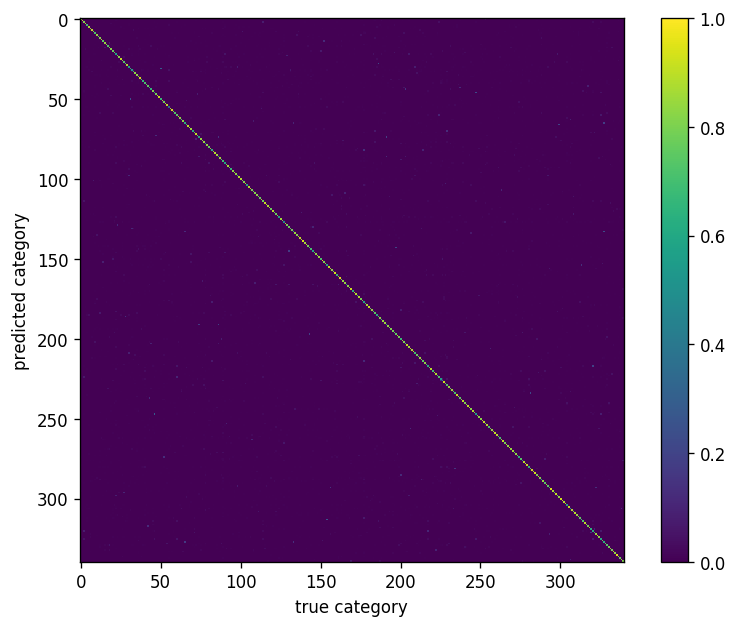

In [10]:
plt.figure(num=None, figsize=(8, 6), dpi=120, facecolor="w", edgecolor="k")
plt.imshow(confusion, vmin=0.0, vmax=1.0)
plt.xlabel("true category")
plt.ylabel("predicted category")
plt.colorbar()

In [11]:
precisions = np.array([confusion[c, c] for c in range(confusion.shape[0])])
percentiles = np.percentile(precisions, q=np.linspace(0, 100, 10))
print(percentiles)

[0.3810316  0.65709247 0.7264536  0.77253217 0.80044295 0.82827622
 0.84735203 0.87847944 0.90235996 0.96311474]


In [12]:
precisions.mean()

0.7949454

In [20]:
precisions[precisions > np.percentile(precisions, q=70)].mean()

0.8950521

In [18]:
np.array(train_data.categories)[precisions > np.percentile(precisions, q=70)]

array(['alarm clock', 'angel', 'ant', 'apple', 'bandage', 'bee',
       'binoculars', 'bowtie', 'butterfly', 'cactus', 'calculator',
       'camel', 'camera', 'campfire', 'candle', 'carrot', 'chair',
       'chandelier', 'clock', 'crown', 'cruise ship', 'donut', 'drill',
       'dumbbell', 'ear', 'envelope', 'eye', 'eyeglasses', 'fireplace',
       'fish', 'flamingo', 'flashlight', 'flip flops', 'flower',
       'giraffe', 'hand', 'harp', 'hat', 'headphones', 'hedgehog',
       'helicopter', 'hot air balloon', 'hourglass', 'ice cream',
       'jacket', 'key', 'ladder', 'lightning', 'lion', 'lipstick',
       'lollipop', 'megaphone', 'mermaid', 'octopus', 'palm tree',
       'panda', 'pants', 'paper clip', 'parachute', 'pig', 'pineapple',
       'pizza', 'popsicle', 'rabbit', 'rain', 'rainbow', 'rhinoceros',
       'rollerskates', 'sailboat', 'saw', 'sea turtle', 'see saw',
       'sheep', 'skateboard', 'skull', 'snail', 'snorkel', 'snowman',
       'sock', 'squirrel', 'stairs', 'star',